In [1]:
# https://github.com/ray-project/ray/blob/master/rllib/examples/sb2rllib_rllib_example.py
import ray
from ray import tune, air
import ray.rllib.algorithms.ppo as ppo

In [2]:
if ray.is_initialized():
    ray.shutdown()
ray.init(num_gpus=1, local_mode=False)

Usage stats collection is enabled by default for nightly wheels. To disable this, run the following command: `ray disable-usage-stats` before starting Ray. See https://docs.ray.io/en/master/cluster/usage-stats.html for more details.


2023-01-08 18:54:45,925	INFO worker.py:1536 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.15
Ray version:,3.0.0.dev0
Dashboard:,http://127.0.0.1:8265


In [3]:
# settings used for both stable baselines and rllib
import gymnasium as gym
import platoonenv

env_name = "Platoon-v2"
env = gym.make(env_name)

print(env_name,"\n------------------")
print("reward_threshold", env.spec.reward_threshold)
print("max_episode_steps", env.spec.max_episode_steps)

Platoon-v2 
------------------
reward_threshold 0
max_episode_steps 20


In [4]:
from ray.rllib.algorithms.ppo import PPOConfig
from ray.rllib.algorithms.dqn import DQNConfig

config = (
    PPOConfig()
    .environment(env_name)
    .framework("torch")
    # .rollouts(num_rollout_workers=10)
    .rollouts(num_rollout_workers=0) # curiosity doesn't support parallelism
    .resources(num_gpus=1)
    .exploration( # https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#curiosity-icm-intrinsic-curiosity-module
        exploration_config={
            "type": "Curiosity",  # <- Use the Curiosity module for exploring.
            "eta": 1.0,  # Weight for intrinsic rewards before being added to extrinsic ones.
            "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
            "feature_dim": 288,  # Dimensionality of the generated feature vectors.
            # Setup of the feature net (used to encode observations into feature (latent) vectors).
            "feature_net_config": {
                "fcnet_hiddens": [],
                "fcnet_activation": "relu",
            },
            "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
            "inverse_net_activation": "relu",  # Activation of the "inverse" model.
            "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
            "forward_net_activation": "relu",  # Activation of the "forward" model.
            "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
            # Specify, which exploration sub-type to use (usually, the algo's "default"
            # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
            "sub_exploration": {
                "type": "StochasticSampling",
            }
        }
    )
)
algo = config.build()

2023-01-08 18:54:49,445	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
2023-01-08 18:54:49,497	INFO policy.py:1196 -- Policy (worker=local) running on 1 GPUs.
2023-01-08 18:54:49,499	INFO torch_policy_v2.py:110 -- Found 1 visible cuda devices.
2023-01-08 18:54:51,425	INFO rollout_worker.py:2037 -- Built policy map: <PolicyMap lru-caching-capacity=100 policy-IDs=['default_policy']>
2023-01-08 18:54:51,425	INFO rollout_worker.py:2038 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x000002550B994E20>}
2023-01-08 18:54:51,426	INFO rollout_worker.py:757 -- Built filter map: defaultdict(<class 'ray.rllib.utils.filter.NoFilter'>, {'default_policy': <ray.rllib.utils.filter.NoFilter object at 0x000002550BA06DF0>})


In [5]:
from glob import glob
from pathlib import Path
save_dir = Path("saved_models","Platoon-v2-curious")
save_dir.mkdir(parents=True, exist_ok=True)
try:
    checkpoint_path = sorted(glob(str(save_dir / "*")))[-1]
    print(f"Restoring from checkpoint: {checkpoint_path}")
    algo.restore(checkpoint_path)
except IndexError as e:
    print(f"Failed to load checkpoint: {e}")

2023-01-08 18:54:51,518	INFO trainable.py:790 -- Restored on 127.0.0.1 from checkpoint: saved_models\Platoon-v2-curious\checkpoint_000181
2023-01-08 18:54:51,519	INFO trainable.py:799 -- Current state after restoring: {'_iteration': 181, '_timesteps_total': None, '_time_total': 5578.578124284744, '_episodes_total': 72800}


Restoring from checkpoint: saved_models\Platoon-v2-curious\checkpoint_000181


In [6]:
from IPython.display import clear_output
def plot(rewards_history):
    clear_output(True)
    plt.figure(figsize=(12, 5))
    plt.title("Training...")
    plt.xlabel("Step")
    plt.ylabel("Rewards")
    plt.plot([x["episode_reward_mean"] for x in rewards_history])
    plt.show()

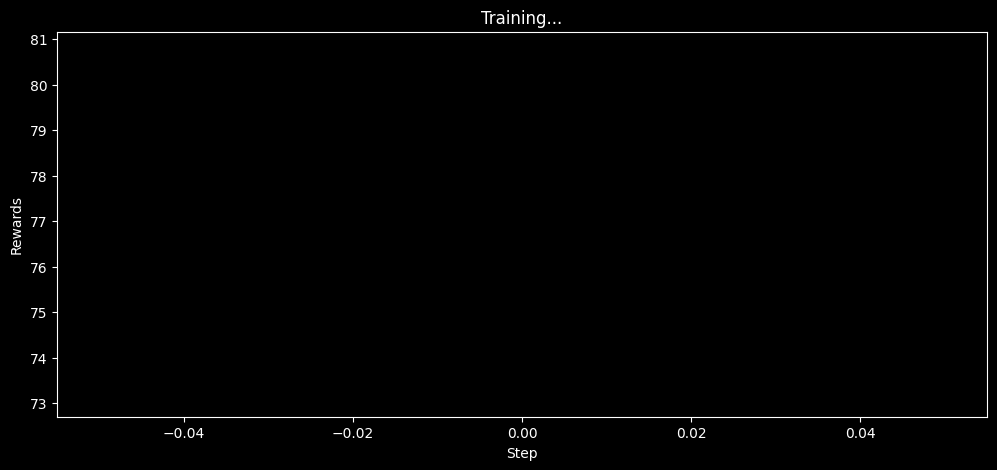

76.935: : 1it [00:35, 35.35s/it]


In [7]:
from tqdm import tqdm
from itertools import count
import matplotlib.pyplot as plt
results_history = []
plot_every = 1
train_steps = 1
with tqdm() as pbar:
    for i in count() if train_steps == 0 else range(train_steps):
        try:
            results = algo.train()
        except KeyboardInterrupt:
            print("Interrupting training")
            checkpoint_path = algo.save(save_dir)
            print(f"Checkpoint saved at: {checkpoint_path}")
            break
        pbar.set_description(str(results["episode_reward_mean"]))
        results_history.append(results)
        pbar.update()
        if i % plot_every == 0:
            plot(results_history)
            pbar.display()
        

In [8]:
results["info"]

{'learner': {'default_policy': {'custom_metrics': {},
   'learner_stats': {'cur_kl_coeff': 0.4500000000000001,
    'cur_lr': 5.0000000000000016e-05,
    'total_loss': 9.620634902420864,
    'policy_loss': -0.06652672709196165,
    'vf_loss': 9.682051417648152,
    'vf_explained_var': 0.6668216268862447,
    'kl': 0.011356052117487034,
    'entropy': 0.9424524944315674,
    'entropy_coeff': 0.0},
   'model': {},
   'num_grad_updates_lifetime': 465.5,
   'diff_num_grad_updates_vs_sampler_policy': 464.5}},
 'num_env_steps_sampled': 732000,
 'num_env_steps_trained': 728000,
 'num_agent_steps_sampled': 732000,
 'num_agent_steps_trained': 728000}

In [9]:
algo.save(save_dir)
# checkpoint path is grabbed by glob when restoring earlier

'saved_models\\Platoon-v2-curious\\checkpoint_000182'

In [10]:
# inference
from ipycanvas import Canvas, hold_canvas
from IPython.display import display
from time import sleep

env = gym.make(env_name)
# obs, info = env.reset(seed=10)
obs, info = env.reset()
reward_total = 0

num_vehicles = obs.shape[0]//2
canvas = Canvas(width=1600, height=900)
display(canvas)
vehicle_width = 80
vehicle_height = 40
padding = 6


for episode_step in count():
    action = algo.compute_single_action(obs)
    next_obs, reward, terminated, truncated, info = env.step(action)
    reward_total += float(reward)

    with hold_canvas():
        for vehicle_index in range(num_vehicles):
            was_member = obs[vehicle_index] > 0
            is_member = next_obs[vehicle_index] > 0
            value = next_obs[vehicle_index+num_vehicles]

            x = vehicle_index*(vehicle_width + padding) + padding
            y = (padding + vehicle_height) * episode_step + padding

            # draw highlight for changed membership
            if is_member != was_member:
                canvas.fill_style = "red"
                canvas.fill_rect(
                    x=x-padding/2,
                    y=y-padding/2,
                    width=vehicle_width+padding,
                    height=vehicle_height+padding,
                )

            # draw vehicle
            if is_member:
                canvas.fill_style = "#55F"
            else:
                canvas.fill_style = "gray"
            canvas.fill_rect(
                x=x,
                y=y,
                width=vehicle_width,
                height=vehicle_height,
            )

            # draw value        
            canvas.font = "20px Consolas"
            canvas.fill_style = "black"
            canvas.fill_text(
                text=f"{value}",
                x=x+vehicle_width/2 - 25,
                y=y+vehicle_height/2 + 7,
            )
        
        # draw text
        canvas.fill_text(
            text=f"action: {action:02d}, reward: {reward_total:+04.0f} ({reward:+.0f})",
            x = x + vehicle_width + 25,
            y = y + 25,
        )

        sleep(0.02)
    if terminated or truncated:
        print(f"ended after {episode_step} steps with reward {reward_total}")
        break
    obs = next_obs

c:\Users\TeamD\.conda\envs\rllib\lib\site-packages\gymnasium\utils\passive_env_checker.py:157: UserWarning: WARN: The obs returned by the `reset()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\TeamD\.conda\envs\rllib\lib\site-packages\gymnasium\utils\passive_env_checker.py:181: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Canvas(height=900, width=1600)

c:\Users\TeamD\.conda\envs\rllib\lib\site-packages\gymnasium\utils\passive_env_checker.py:157: UserWarning: WARN: The obs returned by the `step()` method was expecting numpy array dtype to be float32, actual type: float64
  logger.warn(
c:\Users\TeamD\.conda\envs\rllib\lib\site-packages\gymnasium\utils\passive_env_checker.py:181: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


ended after 9 steps with reward 112.0
